In [11]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random
import sys

import git
import numpy as np
from gym import spaces

path = '/home/carlos/repositorios/habitat-lab/'

%matplotlib inline
from matplotlib import pyplot as plt

# %cd "/content/habitat-lab"
#
#
# if "google.colab" in sys.modules:
#     # This tells imageio to use the system FFMPEG that has hardware acceleration.
#     os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
# repo = git.Repo(".", search_parent_directories=True)
# dir_path = repo.working_tree_dir
# %cd $dir_path

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

In [12]:
# @title Define Observation Display Utility Function { display-mode: "form" }

# @markdown A convenient function that displays sensor observations with matplotlib.

# @markdown (double click to see the code)


# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(
    rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])
):  # noqa: B006
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGB")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new(
            "P", (semantic_obs.shape[1], semantic_obs.shape[0])
        )
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray(
            (depth_obs / 10 * 255).astype(np.uint8), mode="L"
        )
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

## Setup PointNav Task

In [13]:
!cat "/home/carlos/repositorios/habitat-lab/configs/test/habitat_all_sensors_test.yaml"

ENVIRONMENT:
  MAX_EPISODE_STEPS: 10
  ITERATOR_OPTIONS:
    SHUFFLE: False
SIMULATOR:
  AGENT_0:
    SENSORS: ['RGB_SENSOR', 'DEPTH_SENSOR']
  RGB_SENSOR:
    WIDTH: 256
    HEIGHT: 256
  DEPTH_SENSOR:
    WIDTH: 256
    HEIGHT: 256
DATASET:
  TYPE: PointNav-v1
  SPLIT: train
  DATA_PATH: /home/carlos/repositorios/habitat-sim/data/datasets/pointnav/habitat-test-scenes/v1/{split}/{split}.json.gz
TASK:
  TYPE: Nav-v0
  SUCCESS_DISTANCE: 0.2
  SENSORS: ['POINTGOAL_WITH_GPS_COMPASS_SENSOR']
  POSSIBLE_ACTIONS: ['STOP', 'MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT', 'TELEPORT']
  POINTGOAL_WITH_GPS_COMPASS_SENSOR:
    GOAL_FORMAT: "POLAR"
    DIMENSIONALITY: 2
  GOAL_SENSOR_UUID: pointgoal_with_gps_compass

  MEASUREMENTS: ['DISTANCE_TO_GOAL', 'SUCCESS', 'SPL', 'SOFT_SPL']
  SUCCESS:
    SUCCESS_DISTANCE: 0.2


In [14]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_paths= path + "configs/test/habitat_all_sensors_test.yaml"
    )

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

2022-01-26 15:21:32,743 Initializing dataset PointNav-v1
2022-01-26 15:21:32,928 initializing sim Sim-v0
I0126 15:21:33.832461 11760 simulator.py:221] Loaded navmesh data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh
2022-01-26 15:21:33,834 Initializing task Nav-v0


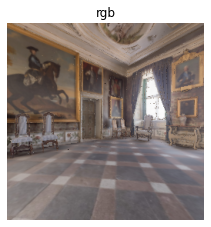

distance to goal: 5.64
angle to goal (radians): 2.88


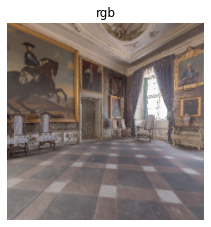

distance to goal: 5.89
angle to goal (radians): 2.89


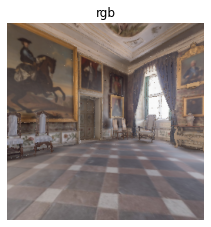

distance to goal: 6.13
angle to goal (radians): 2.90


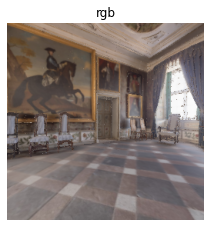

distance to goal: 6.13
angle to goal (radians): 2.73


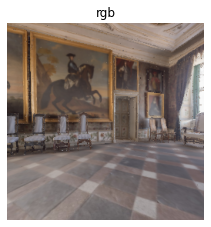

distance to goal: 6.13
angle to goal (radians): 2.55


AssertionError: invalid action {} entered, choose one amongst TURN_LEFT,TURN_RIGHT,MOVE_FORWARD,STOP

In [15]:
    action = None
    obs = env.reset()
    valid_actions = ["TURN_LEFT", "TURN_RIGHT", "MOVE_FORWARD", "STOP"]
    interactive_control = True  # @param {type:"boolean"}
    while action != "STOP":
        display_sample(obs["rgb"])
        print(
            "distance to goal: {:.2f}".format(
                obs["pointgoal_with_gps_compass"][0]
            )
        )
        print(
            "angle to goal (radians): {:.2f}".format(
                obs["pointgoal_with_gps_compass"][1]
            )
        )
        if interactive_control:
            action = input(
                "enter action out of {}:\n".format(", ".join(valid_actions))
            )
            assert (
                action in valid_actions
            ), "invalid action {} entered, choose one amongst " + ",".join(
                valid_actions
            )
        else:
            action = valid_actions.pop()
        obs = env.step(
            {
                "action": action,
            }
        )

    env.close()

In [16]:
    print(env.get_metrics())

{'distance_to_goal': 6.782331466674805, 'success': 0.0, 'spl': 0.0, 'softspl': 0.0}


## RL Training

In [41]:
if __name__ == "__main__":
    config = get_baselines_config(
        path + "habitat_baselines/config/pointnav/ppo_pointnav_example.yaml"
    )

In [42]:
# set random seeds
if __name__ == "__main__":
    seed = "42"  # @param {type:"string"}
    steps_in_thousands = "100"  # @param {type:"string"}

    config.defrost()
    config.TASK_CONFIG.SEED = int(seed)
    config.TOTAL_NUM_STEPS = int(steps_in_thousands)
    config.LOG_INTERVAL = 1
    config.freeze()

    random.seed(config.TASK_CONFIG.SEED)
    np.random.seed(config.TASK_CONFIG.SEED)

In [43]:
if __name__ == "__main__":
    trainer_init = baseline_registry.get_trainer(config.TRAINER_NAME)
    trainer = trainer_init(config)
    trainer.train()

2022-01-26 16:09:42,094 config: BASE_TASK_CONFIG_PATH: /home/carlos/repositorios/habitat-lab/configs/tasks/pointnav.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: -1
CMD_TRAILING_OPTS: []
ENV_NAME: NavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
FORCE_BLIND_POLICY: False
FORCE_TORCH_SINGLE_THREADED: True
LOG_FILE: train.log
LOG_INTERVAL: 1
NUM_CHECKPOINTS: 50
NUM_ENVIRONMENTS: 1
NUM_PROCESSES: -1
NUM_UPDATES: -1
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.t

In [21]:
# @markdown (double click to see the code)

# example tensorboard visualization
# for more details refer to [link](https://github.com/facebookresearch/habitat-lab/tree/main/habitat_baselines#additional-utilities).

try:
    from IPython import display

    with open("./res/img/tensorboard_video_demo.gif", "rb") as f:
        display.display(display.Image(data=f.read(), format="png"))
except ImportError:
    pass

FileNotFoundError: [Errno 2] No such file or directory: './res/img/tensorboard_video_demo.gif'

## Key Concepts

All the concepts link to their definitions:

1. [`habitat.sims.habitat_simulator.HabitatSim`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat/sims/habitat_simulator/habitat_simulator.py#L159)
Thin wrapper over `habitat_sim` providing seamless integration with experimentation framework.


2. [`habitat.core.env.Env`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat/core/env.py)
Abstraction for the universe of agent, task and simulator. Agents that you train and evaluate operate inside the environment.


3. [`habitat.core.env.RLEnv`](https://github.com/facebookresearch/habitat-lab/blob/71d409ab214a7814a9bd9b7e44fd25f57a0443ba/habitat/core/env.py#L278)
Extends the `Env` class for reinforcement learning by defining the reward and other required components.


4. [`habitat.core.embodied_task.EmbodiedTask`](https://github.com/facebookresearch/habitat-lab/blob/71d409ab214a7814a9bd9b7e44fd25f57a0443ba/habitat/core/embodied_task.py#L242)
Defines the task that the agent needs to solve. This class holds the definition of observation space, action space, measures, simulator usage. Eg: PointNav, ObjectNav.


5. [`habitat.core.dataset.Dataset`](https://github.com/facebookresearch/habitat-lab/blob/4b6da1c4f8eb287cea43e70c50fe1d615a261198/habitat/core/dataset.py#L63)
Wrapper over information required for the dataset of embodied task, contains definition and interaction with an `episode`.


6. [`habitat.core.embodied_task.Measure`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat/core/embodied_task.py#L82)
Defines the metrics for embodied task, eg: [SPL](https://github.com/facebookresearch/habitat-lab/blob/d0db1b55be57abbacc5563dca2ca14654c545552/habitat/tasks/nav/nav.py#L533).


7. [`habitat_baselines`](https://github.com/facebookresearch/habitat-lab/tree/71d409ab214a7814a9bd9b7e44fd25f57a0443ba/habitat_baselines)
RL, SLAM, heuristic baseline implementations for the different embodied tasks.

## Create a new Task

In [50]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_paths= path + "configs/test/habitat_all_sensors_test.yaml"
    )


@registry.register_task(name="TestNav-v0")
class NewNavigationTask(NavigationTask):
    def __init__(self, config, sim, dataset):
        logger.info("Creating a new type of task")
        super().__init__(config=config, sim=sim, dataset=dataset)

    def _check_episode_is_active(self, *args, **kwargs):
        logger.info(
            "Current agent position: {}".format(self._sim.get_agent_state())
        )
        collision = self._sim.previous_step_collided
        stop_called = not getattr(self, "is_stop_called", False)
        return collision or stop_called


if __name__ == "__main__":
    config.defrost()
    config.TASK.TYPE = "TestNav-v0"
    config.freeze()

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

2022-01-26 16:14:06,927 Initializing dataset PointNav-v1
2022-01-26 16:14:07,159 initializing sim Sim-v0
I0126 16:14:08.022068 11760 simulator.py:221] Loaded navmesh data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh
2022-01-26 16:14:08,024 Initializing task TestNav-v0
2022-01-26 16:14:08,024 Creating a new type of task


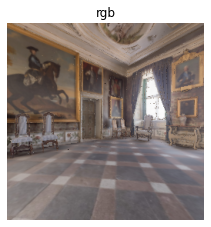

2022-01-26 16:14:09,281 Current agent position: AgentState(position=array([-1.2676634 ,  0.20478529, 12.5954275 ], dtype=float32), rotation=quaternion(0.891185760498047, 0, 0.45363849401474, 0), velocity=array([0., 0., 0.]), angular_velocity=array([0., 0., 0.]), force=array([0., 0., 0.]), torque=array([0., 0., 0.]), sensor_states={'rgb': SixDOFPose(position=array([-1.2676634,  1.4547853, 12.5954275], dtype=float32), rotation=quaternion(0.891185760498047, 0, 0.45363849401474, 0)), 'depth': SixDOFPose(position=array([-1.2676634,  1.4547853, 12.5954275], dtype=float32), rotation=quaternion(0.891185760498047, 0, 0.45363849401474, 0))})


Episode over: True


In [51]:
    action = None
    env.reset()
    valid_actions = ["TURN_LEFT", "TURN_RIGHT", "MOVE_FORWARD", "STOP"]
    interactive_control = False  # @param {type:"boolean"}
    while env.episode_over is not True:
        display_sample(obs["rgb"])
        if interactive_control:
            action = input(
                "enter action out of {}:\n".format(", ".join(valid_actions))
            )
            assert (
                action in valid_actions
            ), "invalid action {} entered, choose one amongst " + ",".join(
                valid_actions
            )
        else:
            action = valid_actions.pop()
        obs = env.step(
            {
                "action": action,
                "action_args": None,
            }
        )
        print("Episode over:", env.episode_over)

    env.close()

## Create a new Sensor

In [ ]:
@registry.register_sensor(name="agent_position_sensor")
class AgentPositionSensor(habitat.Sensor):
    def __init__(self, sim, config, **kwargs):
        super().__init__(config=config)
        self._sim = sim

    # Defines the name of the sensor in the sensor suite dictionary
    def _get_uuid(self, *args, **kwargs):
        return "agent_position"

    # Defines the type of the sensor
    def _get_sensor_type(self, *args, **kwargs):
        return habitat.SensorTypes.POSITION

    # Defines the size and range of the observations of the sensor
    def _get_observation_space(self, *args, **kwargs):
        return spaces.Box(
            low=np.finfo(np.float32).min,
            high=np.finfo(np.float32).max,
            shape=(3,),
            dtype=np.float32,
        )

    # This is called whenver reset is called or an action is taken
    def get_observation(self, observations, *args, episode, **kwargs):
        return self._sim.get_agent_state().position

In [ ]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_paths="./configs/test/habitat_all_sensors_test.yaml"
    )

    config.defrost()
    # Now define the config for the sensor
    config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
    # Use the custom name
    config.TASK.AGENT_POSITION_SENSOR.TYPE = "agent_position_sensor"
    # Add the sensor to the list of sensors in use
    config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")
    config.freeze()

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

In [ ]:
    obs = env.reset()

In [ ]:
    obs.keys()

In [ ]:
    print(obs["agent_position"])

In [ ]:
    env.close()

## Create a new Agent

In [ ]:
# An example agent which can be submitted to habitat-challenge.
# To participate and for more details refer to:
# - https://aihabitat.org/challenge/2020/
# - https://github.com/facebookresearch/habitat-challenge


class ForwardOnlyAgent(habitat.Agent):
    def __init__(self, success_distance, goal_sensor_uuid):
        self.dist_threshold_to_stop = success_distance
        self.goal_sensor_uuid = goal_sensor_uuid

    def reset(self):
        pass

    def is_goal_reached(self, observations):
        dist = observations[self.goal_sensor_uuid][0]
        return dist <= self.dist_threshold_to_stop

    def act(self, observations):
        if self.is_goal_reached(observations):
            action = HabitatSimActions.STOP
        else:
            action = HabitatSimActions.MOVE_FORWARD
        return {"action": action}

### Other Examples

[Create a new action space](https://github.com/facebookresearch/habitat-lab/blob/main/examples/new_actions.py)

In [ ]:
# @title Sim2Real with Habitat { display-mode: "form" }

try:
    from IPython.display import HTML

    HTML(
        '<iframe width="560" height="315" src="https://www.youtube.com/embed/Hun2rhgnWLU" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
    )
except ImportError:
    pass

Deploy habitat-sim trained models on real robots with the [habitat-pyrobot bridge](https://github.com/facebookresearch/habitat-lab/blob/71d409ab214a7814a9bd9b7e44fd25f57a0443ba/habitat/sims/pyrobot/pyrobot.py)

```python
# Are we in sim or reality?
if args.use_robot: # Use LoCoBot via PyRobot
    config.SIMULATOR.TYPE = "PyRobot-Locobot-v0"
else: # Use simulation
    config.SIMULATOR.TYPE = "Habitat-Sim-v0"
```

Paper: [https://arxiv.org/abs/1912.06321](https://arxiv.org/abs/1912.06321)